# Train scVI on lupus data

Shuffle the disease labels

In [64]:
import os
import tempfile
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import torch
from rich import print
import matplotlib.pyplot as plt

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 0.20.3

In [3]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

### Read the lupus data and preprocess

Can run this section just once

In [ ]:
# data_path = '/home/ssm-user/Data/'

# adata = sc.read(data_path + './Lupus_study_adjusted_counts_cM_filtered.h5ad')
# adata.layers['counts'] = adata.X.copy()

# adata.raw = adata  # keep full dimension safe
# sc.pp.highly_variable_genes(
#     adata,
#     flavor="seurat_v3",
#     n_top_genes=10000,
#     layer="counts",
#     batch_key="batch_cov",
#     subset=True,
# )

# adata.write(data_path + './lupus_cM_hvg.h5ad')

### Shuffle the SLE status at the donor level and train scVI

In [ ]:
n_trial = 10

for trial in range(n_trial):
    
    adata = sc.read(data_path + './lupus_cM_hvg.h5ad')
    donor_status = adata.obs[['ind_cov', 'SLE_status']].drop_duplicates().reset_index()
    shuffled_donor_status = donor_status.copy().reset_index()
    shuffled_donor_status['shuffled_SLE_status'] = shuffled_donor_status['SLE_status'].sample(frac=1).values
    shuffled_donor_status.drop('SLE_status', axis=1, inplace=True)
    adata.obs = pd.merge(adata.obs, shuffled_donor_status, on='ind_cov', how='left')
    
    scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch_cov")
    model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
    model.train()
    model.save(data_path + f'lupus/shuffled_scvi_cM_batch_{trial}')
    result = model.differential_expression(adata=adata, groupby='shuffled_SLE_status', group1='Healthy', group2='SLE', mode='change', delta=0.05)
    result.to_csv(data_path + f'lupus/shuffled_scvi_result_{trial}.csv')


### Plot scvi result

In [54]:
num_de = np.zeros(n_trial)
for  trial in range(n_trial):
    
    df = pd.read_csv(data_path + f'lupus/shuffled_scvi_result_{trial}.csv', index_col=0)
    num_de[trial] = df.query('bayes_factor > 3').shape[0]/df.shape[0]
    

In [71]:
table = pd.DataFrame(num_de, columns=['fdr'])
table['method'] = 'scVI'

memento_table = pd.DataFrame([0.00666405, 0.0246962 , 0.03469228, 0.13426107], columns=['fdr'])
memento_table['method'] = 'memento\n(P<0.05)'

memento_table2 = pd.DataFrame([0., 0. , 0., 0.], columns=['fdr'])
memento_table2['method'] = 'memento\n(Adjusted P <0.05)'

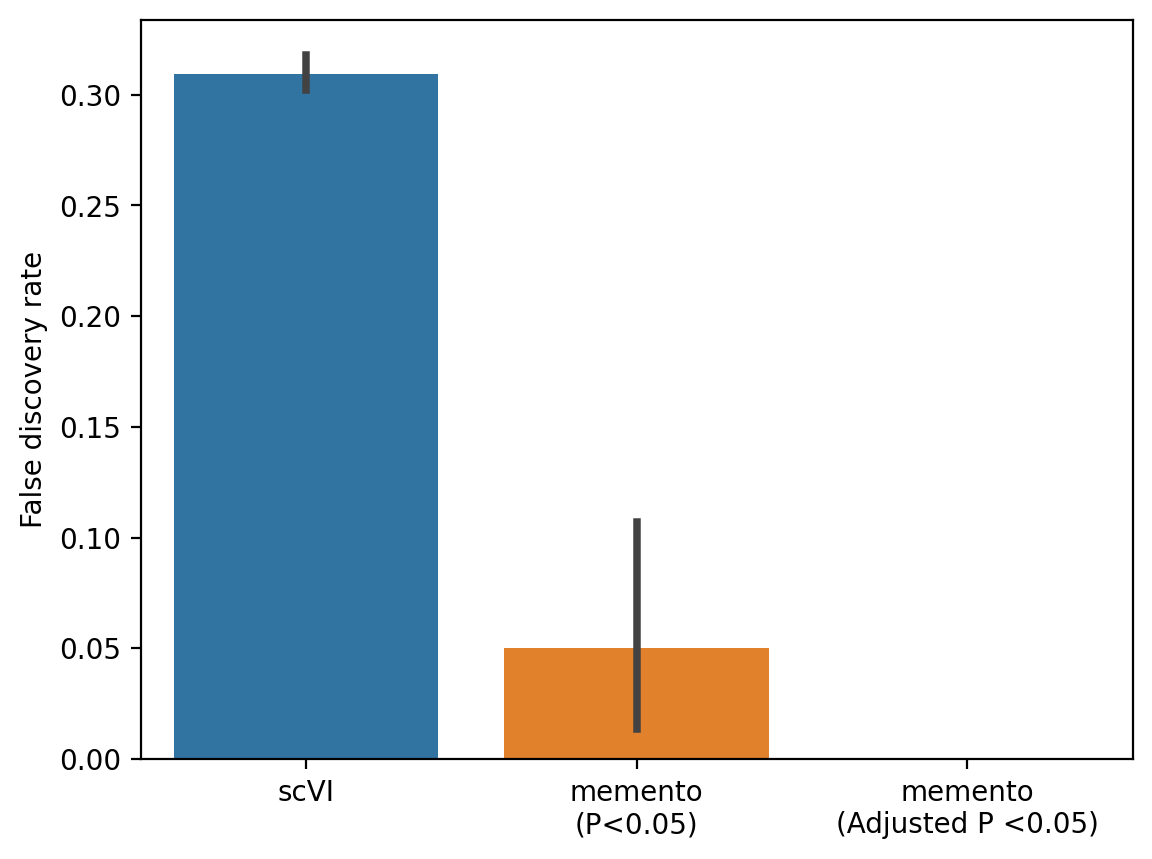

In [73]:
sns.barplot(x='method', y='fdr', data=pd.concat([table, memento_table, memento_table2]))
plt.ylabel('False discovery rate')
plt.xlabel(None)
plt.savefig('memento_comparison.png', bbox_inches='tight')

In [53]:
pd.concat([table, pd.DataFrame([(0, 'memento')], columns=['num_de', 'method'])])

,num_de,method
0,0.3294,scVI
1,0.2921,scVI
2,0.2974,scVI
3,0.3103,scVI
4,0.3078,scVI
5,0.3023,scVI
6,0.3130,scVI
7,0.3356,scVI
8,0.3011,scVI
9,0.3030,scVI


In [35]:
table

,num_de,method
0,8771.0,scVI
1,8247.0,scVI
2,8308.0,scVI
3,8563.0,scVI
4,8504.0,scVI
5,8369.0,scVI
6,8578.0,scVI
7,8864.0,scVI
8,8470.0,scVI
9,8405.0,scVI


In [21]:
list(num_de)

[8771.0,
 8247.0,
 8308.0,
 8563.0,
 8504.0,
 8369.0,
 8578.0,
 8864.0,
 8470.0,
 8405.0]

In [22]:
import seaborn as sns

<Axes: >

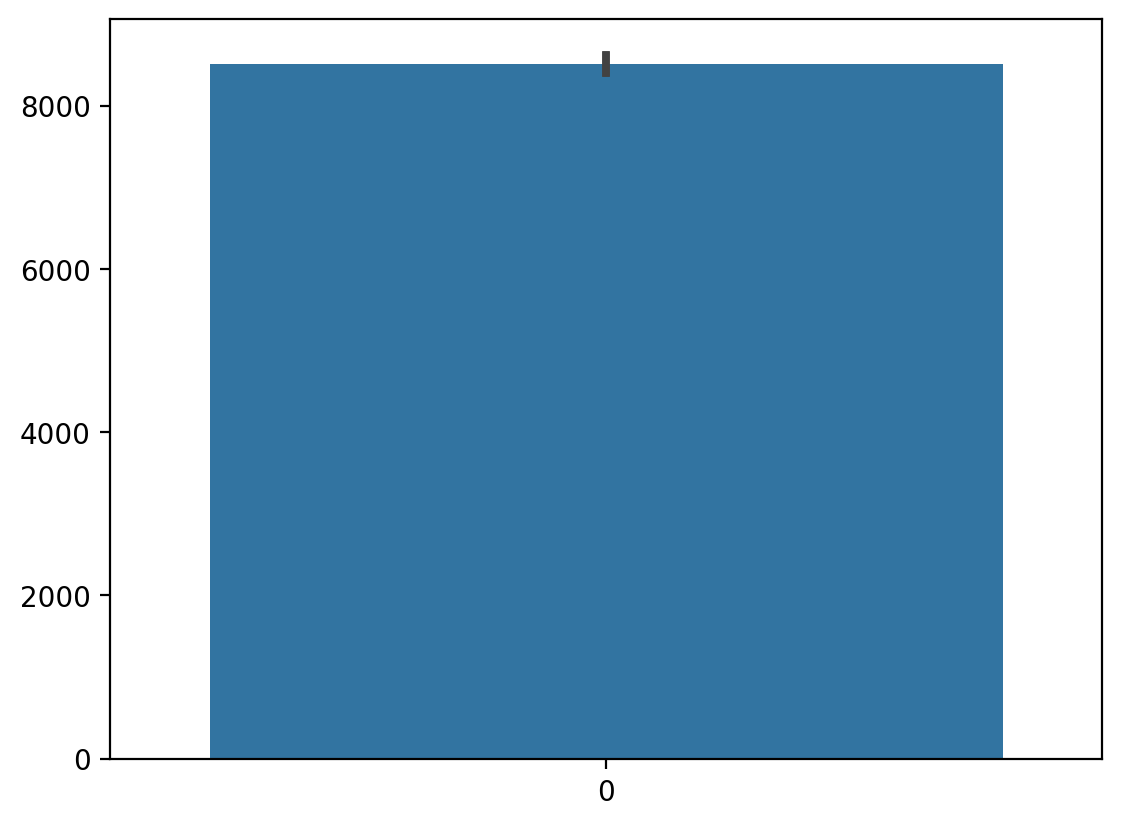

In [30]:
sns.barplot(num_de, errorbar=('ci', 95))
sns.barplot(num_de, errorbar=('ci', 95))